/home/isabrand/.conda/envs/odl/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/isabrand/.conda/envs/odl/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[[         0          0          0 ... 4294967295 4294967295 4294967295]
 [         0          0          0 ... 4294967295 4294967295 4294967295]
 [         0          0          0 ... 4294967295 4294967295 4294967295]
 ...
 [4294967295 4294967295 4294967295 ... 4294967295 4294967295 4294967295]
 [4294967295 4294967295 4294967295 ... 4294967295 4294967295 4294967295]
 [4294967295 4294967295 4294967295 ... 4294967295 4294967295 4294967295]]
Whidbey-Seattle Cable total length: 5.59 km
Whidbey-Seattle Cable total length: 11.86 km
Whidbey-Seattle Cable total length: 47.53 km


/home/isabrand/.conda/envs/odl/lib/python3.12/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


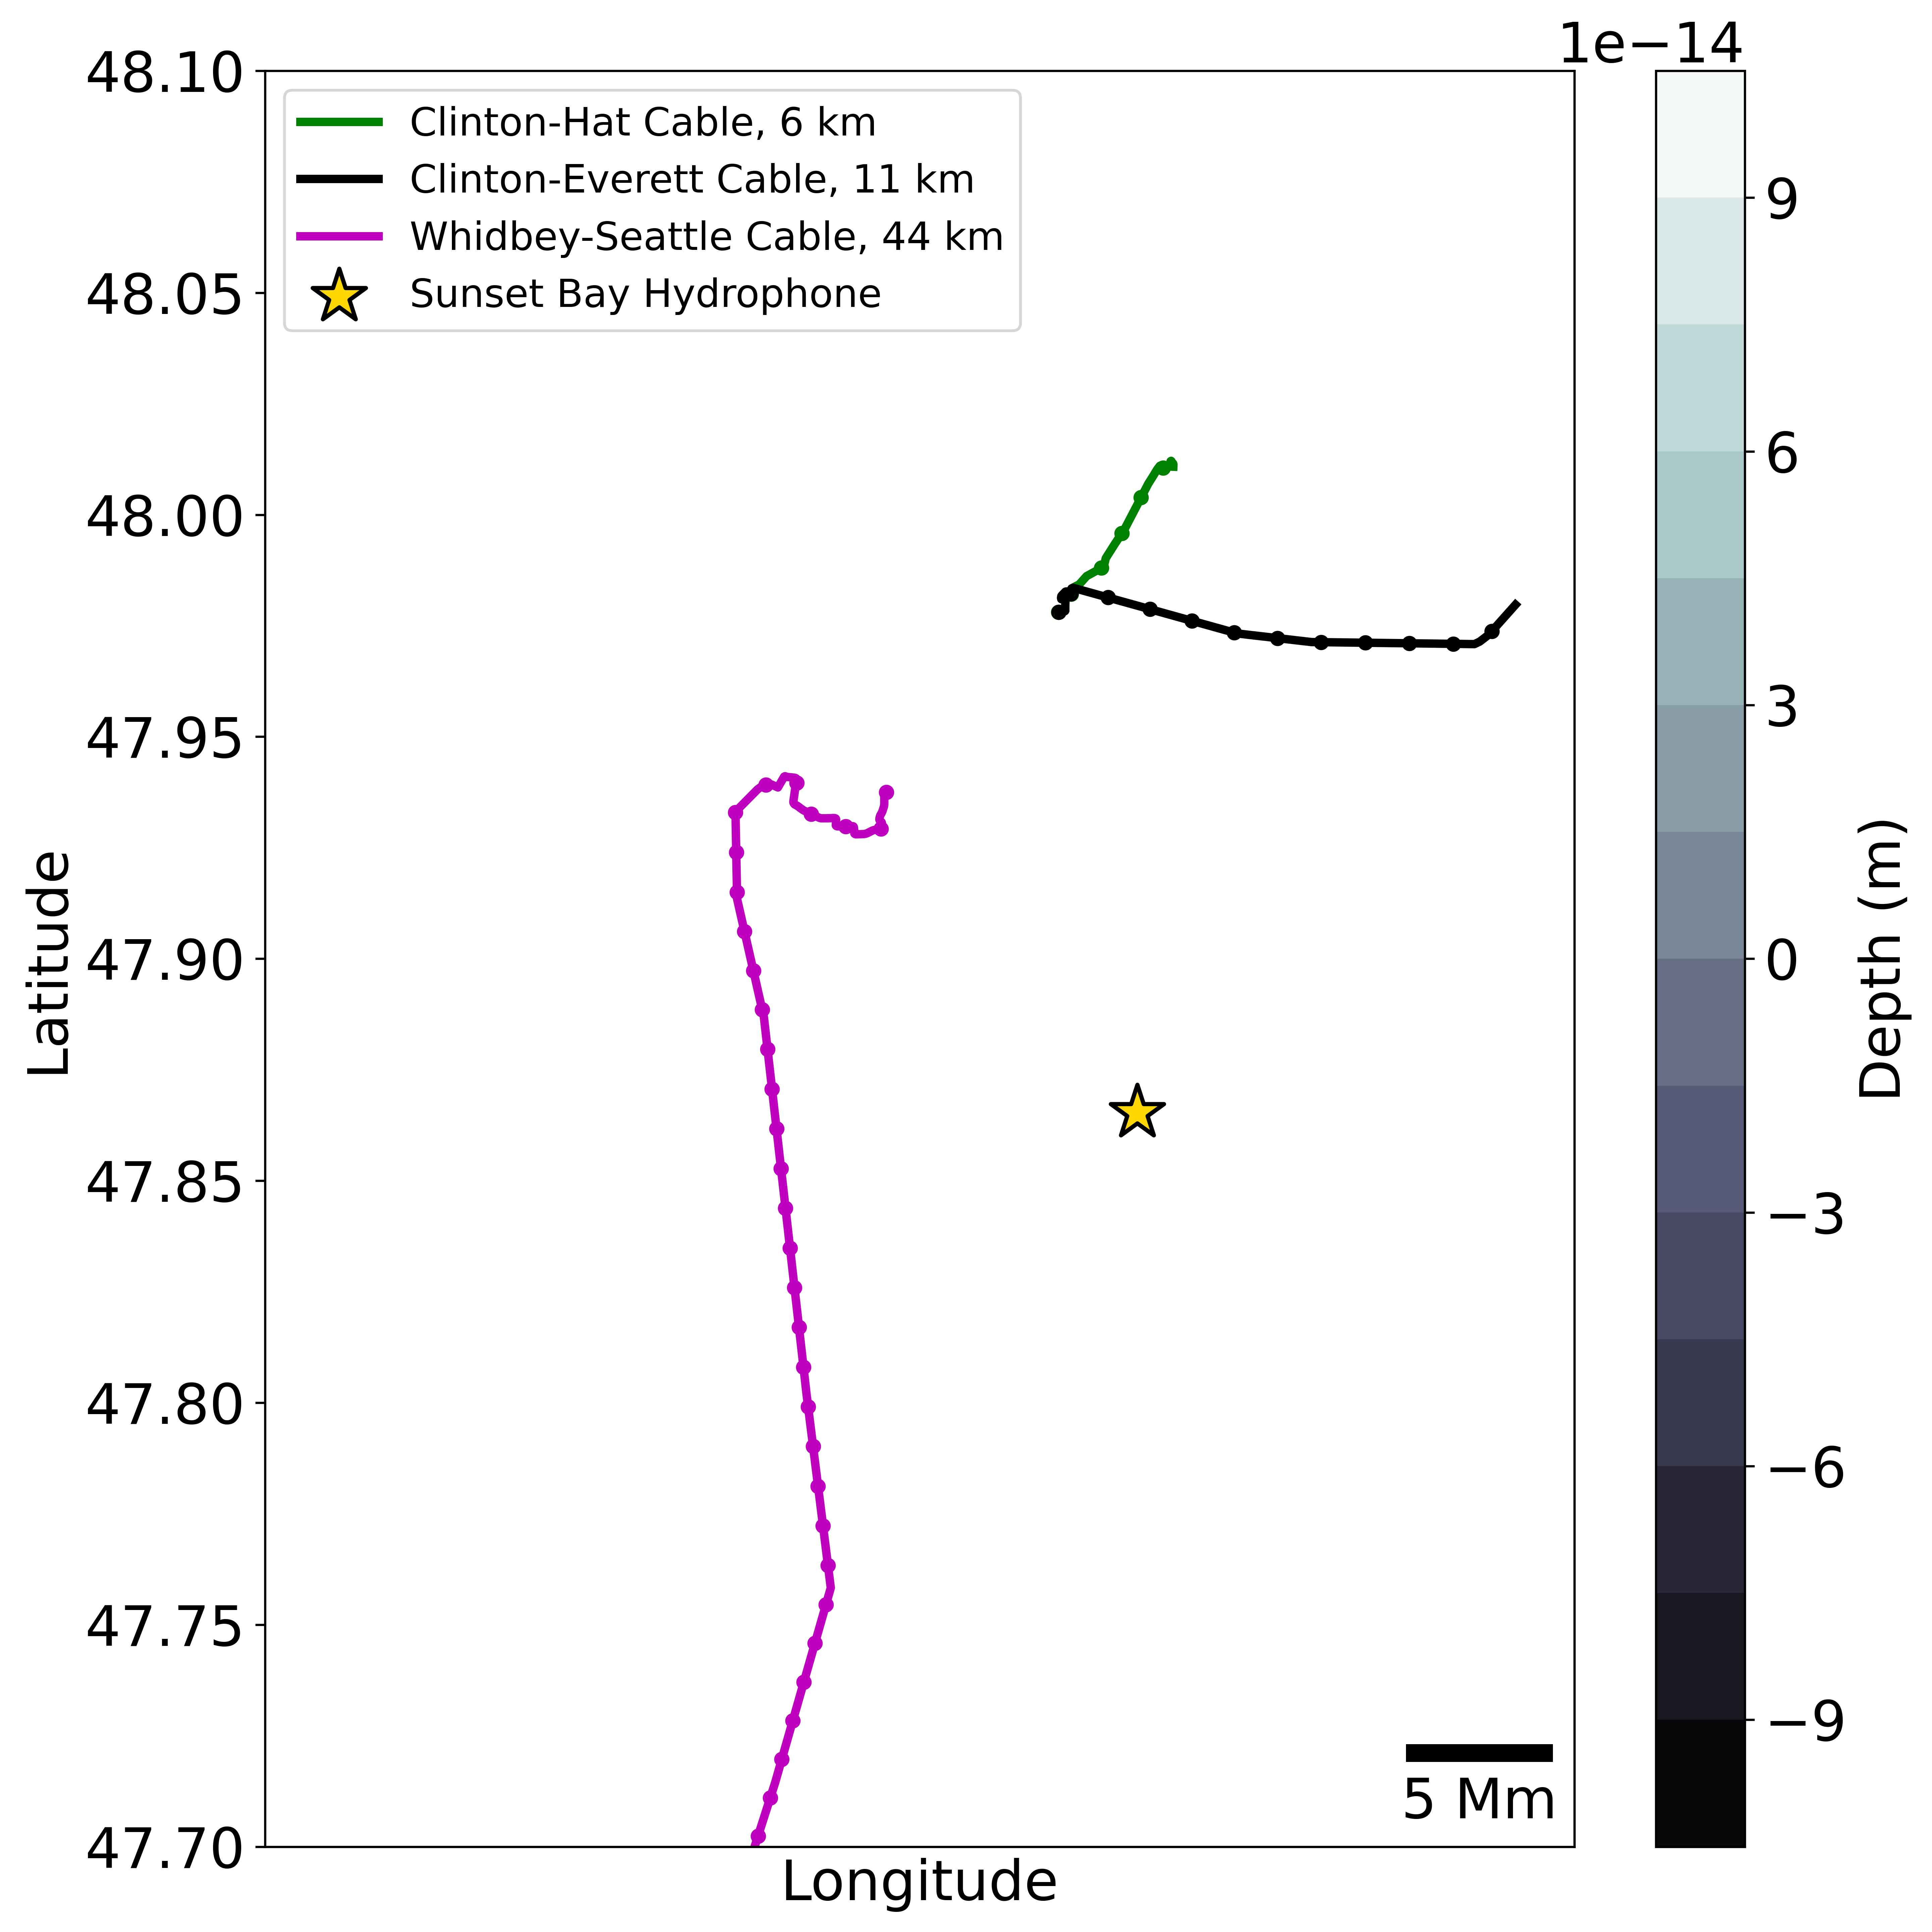

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from matplotlib_scalebar.scalebar import ScaleBar
from math import radians, sin, cos, sqrt, atan2

#plt.rcParams.update({"font.size": 20})
# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))


####### Add correct paths here ##################

# File paths
bathy_file = "/home/isabrand/Documents/ODL/Bathymetry/SalishSea.tiff"
cable1_file = "/home/isabrand/Documents/ODL/Bathymetry/Clinton_Hat_cablepath.csv"
cable2_file = "/home/isabrand/Documents/ODL/Bathymetry/Clinton_Everett_cablepath.csv"
cable3_file = "/home/isabrand/Documents/ODL/Bathymetry/Whidbey_Seattle_cablepath.csv"

# Load bathymetry data
with rasterio.open(bathy_file) as dataset:
    bathy = dataset.read(1)
    transform = dataset.transform
    bounds = dataset.bounds
    nodata = dataset.nodata
print(bathy)

rows, cols = bathy.shape
x = np.linspace(bounds.left, bounds.right, cols)
y = np.linspace(bounds.top, bounds.bottom, rows)
lon_grid, lat_grid = np.meshgrid(x, y)
bathy = np.where(bathy == nodata, np.nan, bathy)

# Separate depth and elevation
depth = np.where(bathy < 0, bathy, np.nan)
elevation = np.where(bathy >= 0, bathy, np.nan)

# Load cable CSVs
cable1 = pd.read_csv(cable1_file)
cable2 = pd.read_csv(cable2_file)
cable3 = pd.read_csv(cable3_file)


from scipy.interpolate import interp1d

# Function to interpolate points every N km along a cable
def interpolate_cable(lons, lats, interval_km=1):
    dists = [0]
    for i in range(1, len(lons)):
        d = haversine(lats[i-1], lons[i-1], lats[i], lons[i])
        dists.append(dists[-1] + d)
    
    total_dist = dists[-1]
    print(f"Whidbey-Seattle Cable total length: {total_dist:.2f} km")

    interp_dists = np.arange(0, total_dist, interval_km)
    
    f_lon = interp1d(dists, lons)
    f_lat = interp1d(dists, lats)
    
    interp_lons = f_lon(interp_dists)
    interp_lats = f_lat(interp_dists)
    
    return np.column_stack((interp_lons, interp_lats))

# Interpolate both cables
interp_points1 = interpolate_cable(cable1["Long"].values, cable1["Lat"].values)
interp_points2 = interpolate_cable(cable2["Long"].values, cable2["Lat"].values)
interp_points3 = interpolate_cable(cable3["longitude"].values, cable3["latitude"].values)

# Sample bathymetry values at those points
with rasterio.open(bathy_file) as dataset:
    depths1 = list(dataset.sample(interp_points1))
    depths2 = list(dataset.sample(interp_points2))
    depths3 = list(dataset.sample(interp_points3))

depths1 = np.array([val[0] for val in depths1])
depths2 = np.array([val[0] for val in depths2])
depths3 = np.array([val[0] for val in depths3])

# Convert nodata to NaN
depths1 = np.where(depths1 == nodata, np.nan, depths1)
depths2 = np.where(depths2 == nodata, np.nan, depths2)
depths3 = np.where(depths3 == nodata, np.nan, depths3)

# DEBUG: Print a few results
# print("\nSampled Clinton-Hat Cable Depths (every 500 m):")
# for i, (lon, lat, d) in enumerate(zip(interp_points1[:, 0], interp_points1[:, 1], depths1)):
#     print(f"{i*0.5:.1f} km: Lon = {lon:.5f}, Lat = {lat:.5f}, Depth = {d:.2f} m")

# print("\nSampled Clinton-Everett Cable Depths (every 500 m):")
# for i, (lon, lat, d) in enumerate(zip(interp_points2[:, 0], interp_points2[:, 1], depths2)):
#     print(f"{i*0.5:.1f} km: Lon = {lon:.5f}, Lat = {lat:.5f}, Depth = {d:.2f} m")


# Plot
plt.rcParams.update({"font.size": 20})
plt.figure(figsize=(10, 10),dpi=600)
cp_depth = plt.contourf(lon_grid, lat_grid, depth, levels=18, cmap="bone")
cbar_depth = plt.colorbar(cp_depth, label="Depth (m)")
cp_elevation = plt.contourf(lon_grid, lat_grid, elevation, levels=20, cmap="copper", alpha=0.6)
#plt.colorbar(cp_elevation, label="Elevation (m)")

# Plot cables
plt.plot(cable1["Long"], cable1["Lat"], color="green", linewidth=3, label="Clinton-Hat Cable, 6 km")
plt.plot(cable2["Long"], cable2["Lat"], color="black", linewidth=3, label="Clinton-Everett Cable, 11 km")
plt.plot(cable3["longitude"], cable3["latitude"], color="m", linewidth=3, label="Whidbey-Seattle Cable, 44 km")
# Add the Sunset Bay Hydrophone with an outline
plt.scatter(-122.333520, 47.865357, color="gold", s=400, marker="*", label="Sunset Bay Hydrophone", edgecolors="black", linewidths=1.5)


plt.scatter(interp_points1[:, 0], interp_points1[:, 1], color="green", s=20)
plt.scatter(interp_points2[:, 0], interp_points2[:, 1], color="black", s=20)
plt.scatter(interp_points3[:, 0], interp_points3[:, 1], color="m", s=20)


# Labels and zoom

plt.xlabel("Longitude", fontsize=20)
plt.xticks(ticks=plt.xticks()[0], labels=[label if i % 2 == 0 else "" for i, label in enumerate(plt.xticks()[1])])
plt.ylabel("Latitude", fontsize=20)
#plt.title("DAS Cables with Bathymetry", fontsize=16)
plt.xlim(-122.6,-122.2)
plt.ylim(47.7, 48.1)
plt.legend(loc="upper left", fontsize=14)

# Add scalebar
scalebar = ScaleBar(dx=transform[0] * 111320, units="km", location="lower right")
plt.gca().add_artist(scalebar)


# Zoom to cable region
# all_lats = np.concatenate([cable1['Lat'].values, cable2['Lat'].values])
# all_lons = np.concatenate([cable1['Long'].values, cable2['Long'].values])
# plt.xlim(all_lons.min() - 0.01, all_lons.max() + 0.01)
# plt.ylim(all_lats.min() - 0.01, all_lats.max() + 0.01)

# Label depths every 1 km for Clinton-Hat cable
# for i in range(1, len(depths1), 2):  # 2 * 0.5 km = 1 km intervals
#     lon, lat, d = interp_points1[i, 0], interp_points1[i, 1], depths1[i]
#     if not np.isnan(d) and d < 0:  # Only label if depth is negative and not NaN
#         plt.text(lon, lat, f"{int(round(d))} m", fontsize=10, ha="right", va="bottom", color="black")

# # Label depths every 1 km for Clinton-Everett cable
# for i in range(1, len(depths2), 2):  # 2 * 0.5 km = 1 km intervals
#     lon, lat, d = interp_points2[i, 0], interp_points2[i, 1], depths2[i]
#     if not np.isnan(d) and d < 0:  # Only label if depth is negative and not NaN
#         plt.text(lon, lat, f"{int(round(d))} m", fontsize=10, ha="left", va="bottom", color="black")


plt.tight_layout()
plt.show()

# # Export Clinton-Hat Island cable depth samples
# output1 = pd.DataFrame({
#     "Distance_km": np.arange(0, len(depths1) * 0.5, 0.5),
#     "Longitude": interp_points1[:, 0],
#     "Latitude": interp_points1[:, 1],
#     "Depth_m": depths1
# })
# output1.to_csv(r"C:\Users\sjuber\OneDrive - UW\DAS4Orcas\WhidbeyData\Clinton_HatIsland_Cable_Depths.csv", index=False)

# # Export Clinton-Everett cable depth samples
# output2 = pd.DataFrame({
#     "Distance_km": np.arange(0, len(depths2) * 0.5, 0.5),
#     "Longitude": interp_points2[:, 0],
#     "Latitude": interp_points2[:, 1],
#     "Depth_m": depths2
# })
# output2.to_csv(r"C:\Users\sjuber\OneDrive - UW\DAS4Orcas\WhidbeyData\Clinton_Everett_Cable_Depths.csv", index=False)

# print("CSV files saved: 'Clinton_HatIsland_Cable_Depths.csv' and 'Clinton_Everett_Cable_Depths.csv'")

# # Export Clinton-Everett cable depth samples
# output3 = pd.DataFrame({
#     "Distance_km": np.arange(0, len(depths3) * 0.5, 0.5),
#     "Longitude": interp_points3[:, 0],
#     "Latitude": interp_points3[:, 1],
#     "Depth_m": depths3
# })
# output3.to_csv(r"C:\Users\sjuber\OneDrive - UW\DAS4Orcas\WhidbeyData\Whidbey_Seattle_Cable_Depths.csv", index=False)

# print("CSV file saved: 'Whidbey_Seattle_Cable_Depths.csv'")







In [6]:
depth

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])